In [1]:
# importing  the necessary libraries
import requests
import numpy as np 
import cv2
import json
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from keras.models import Sequential
from keras import regularizers
from keras.layers.core import Dropout
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.datasets import fashion_mnist

In [2]:
# loading the data
(x_train,y_train), (x_test,y_test) = fashion_mnist.load_data()

In [3]:
# checking the shape of the data
print("X test: ", x_test.shape)
print("X train: ", x_train.shape)
print("Y test: ", y_test.shape)
print("Y train: ", y_train.shape)

(60000, 28, 28)

From the shape, the images do not have their RGB channels.

In [4]:
# converting the images to RGB
x_train_3ch = np.stack([x_train]*3, axis=-1)
x_test_3ch = np.stack([x_test]*3, axis=-1)

In [5]:
# viewing the changes
x_train_3ch.shape

(60000, 28, 28, 3)

In [6]:
# function to resize images
def resize_image_array(img, img_size_dims):
  img = cv2.resize(img, dsize=img_size_dims, interpolation=cv2.INTER_CUBIC)
  img = np.array(img, dtype=np.float32)
  return img

In [7]:
# dimension to rezize the image to
IMG_DIMS = (32, 32)

x_train_reshaped = np.array([resize_image_array(img, IMG_DIMS) for img in x_train_3ch])
x_test_reshaped = np.array([resize_image_array(img, IMG_DIMS) for img in x_test_3ch])

In [8]:
# viewing the resized images
x_train_reshaped.shape

(60000, 32, 32, 3)

In [9]:
# importing the pre-trained VGG19 model
from keras.applications.vgg19 import VGG19
INPUT_SHAPE = (32, 32, 3)

# viewing the model structure
vgg_layer = VGG19(weights = 'imagenet' , include_top = False, input_shape = INPUT_SHAPE)
vgg_layer.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [10]:
# unfreezing the VGG19 layers and making them trainiable
for layer in vgg_layer.layers:
  layer.trainable = True

In [15]:
# creating a new fully connected layer and adding the VGG19 as a layer in our new sequential model
model = Sequential()
model.add(vgg_layer)
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation = 'softmax'))

model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

In [ ]:
# normalizing the data
x_train_scaled = x_train_reshaped/255.0
x_test_scaled = x_test_reshaped/255.0

# setting callbacks to monitor model performance and make decisions
from keras.callbacks import EarlyStopping

# monitoring the loss and validation loss
my_callbacks = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True,  verbose=1)

In [16]:
# fitting the model
history = model.fit(x_train_scaled, y_train, batch_size = 100, callbacks = my_callbacks, validation_data = (x_test_scaled, y_test), epochs=100, verbose=1)

Epoch 1/100
600/600 [==============================] - 39s 62ms/step - loss: 0.8046 - accuracy: 0.8251 - val_loss: 0.3237 - val_accuracy: 0.8956
Epoch 2/100
600/600 [==============================] - 36s 61ms/step - loss: 0.2777 - accuracy: 0.9112 - val_loss: 0.3386 - val_accuracy: 0.8826
Epoch 3/100
600/600 [==============================] - 37s 61ms/step - loss: 0.2959 - accuracy: 0.9038 - val_loss: 0.3140 - val_accuracy: 0.9105
Epoch 4/100
600/600 [==============================] - 38s 63ms/step - loss: 0.2323 - accuracy: 0.9294 - val_loss: 0.2693 - val_accuracy: 0.9115
Epoch 5/100
600/600 [==============================] - 37s 62ms/step - loss: 0.2161 - accuracy: 0.9307 - val_loss: 0.3172 - val_accuracy: 0.9139
Epoch 6/100
600/600 [==============================] - 38s 64ms/step - loss: 0.2181 - accuracy: 0.9321 - val_loss: 0.2846 - val_accuracy: 0.9093
Epoch 7/100
600/600 [==============================] - 38s 64ms/step - loss: 0.1964 - accuracy: 0.9355 - val_loss: 0.2530 - val_ac

In [22]:
# Evaluating the models performance
train_score = model.evaluate(x_train_scaled, y_train, verbose = 0)
test_score = model.evaluate(x_test_scaled, y_test, verbose = 0)

In [25]:
# Printing out the metrics
print(f'Train Accuracy: {train_score[1] * 100}%')
print(f'Train Loss: {train_score[0]}')
print(f'Test Accuracy : {test_score[1] * 100}%')
print(f'Test Loss : {test_score[0]}')

Train Accuracy: 94.9750006198883%
Train Loss: 0.14971230924129486
Test Accuracy : 91.71000123023987%
Test Loss : 0.25186920166015625


Text(0.5, 0, 'epoch')

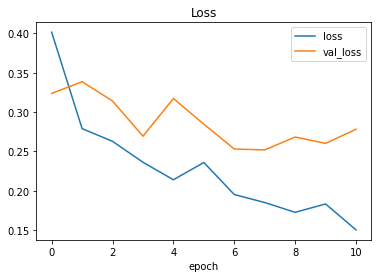

In [27]:
# visualizing the loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

Text(0.5, 0, 'epoch')

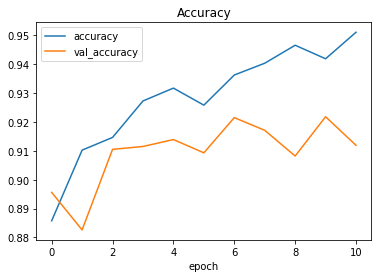

In [28]:
# Visualizing the accuracy and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

In [26]:
# Saving the model
model.save("Transfer_Learning.h5")